<a href="https://colab.research.google.com/github/rickiepark/the-ml-book/blob/main/Ch09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9장 비지도 학습

## 9.1 밀도 추정

/tmp/ipython-input-1-3111518676.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  s = integrate.quad(fb2, -np.inf, np.inf)[0] - 2.0*np.mean([fbi(i, x, bi) for i in range(len(x))])
/tmp/ipython-input-1-3111518676.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  s = integrate.quad(fb2, -np.inf, np.inf)[0] - 2.0*np.mean([fbi(i, x, bi) for i in range(len(x))])


0.8254545454545456


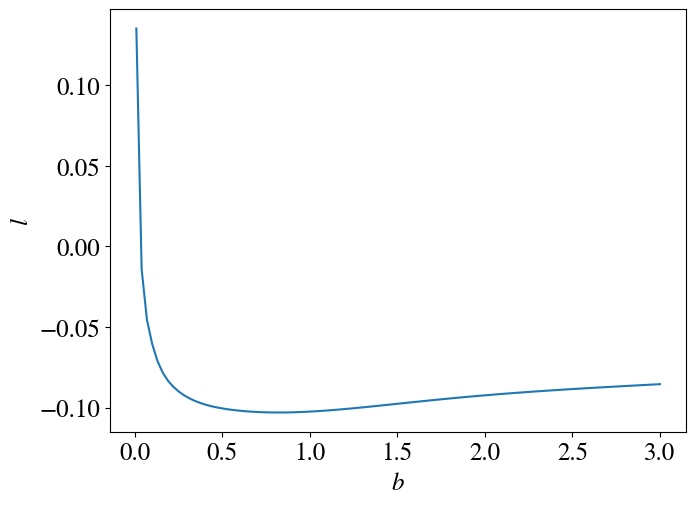

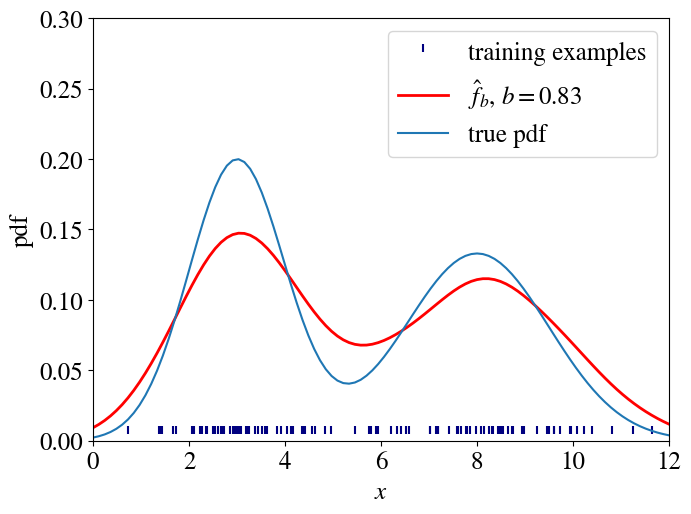

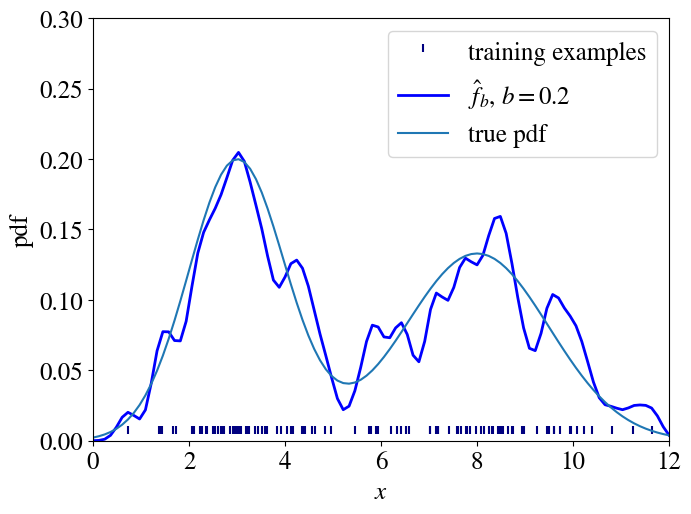

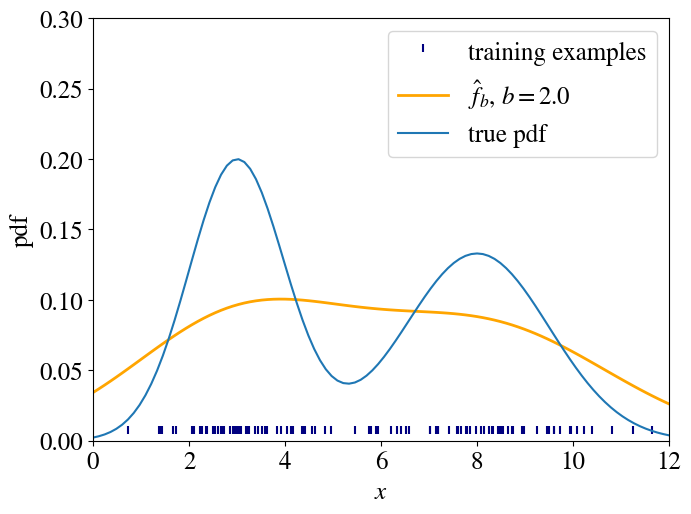

In [1]:
from __future__ import print_function
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KernelDensity

import scipy.integrate as integrate
from sklearn.kernel_ridge import KernelRidge

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})

mu1, sigma1 = 3.0, 1.0
mu2, sigma2 = 8.0, 1.5

def sample_points():
    s1 = np.random.normal(mu1, sigma1, 50)

    s2 = np.random.normal(mu2, sigma2, 50)

    return list(s1) + list(s2)

# generate points used to plot
x_plot = np.linspace(0, 12, 100)

# generate points and keep a subset of them
x = sample_points()

colors = ['red', 'blue', 'orange', 'green']
lw = 2

def kernel(x1, x2, bi = 2.0):
    z = (x1 - x2) / bi
    return (1.0/math.sqrt(2.0 * 3.14)) * math.exp((-1.0/2.0)*(z**2))

def fb(xx, data, bi):
    return (1/(len(data)*bi)) * sum([kernel(xx, xi, bi) for xi in data])

def fbi(i, data, bi):
    data_minus_i = []
    for ii in range(len(data)):
        if i != ii:
            data_minus_i.append(data[ii])
    return (1/(len(data_minus_i)*bi)) * sum([kernel(data[i], xi, bi) for xi in data_minus_i])


def sum_pdf(x):
    result = []
    for i in range(len(x)):
        result.append((sp.stats.norm.pdf(x, mu1, sigma1)[i] + sp.stats.norm.pdf(x, mu2, sigma2)[i])/2.0)
        #result.append(sp.stats.norm.pdf(x, mu1, sigma1)[i])
    return result

b = np.linspace(0.01, 3.0, 100)

score = []
for bi in b:
    def fb2(xx):
        return fb(xx, x, bi)**2

    s = integrate.quad(fb2, -np.inf, np.inf)[0] - 2.0*np.mean([fbi(i, x, bi) for i in range(len(x))])
    score.append(s)

plt.figure(1)
plt.plot(b,score)
plt.xlabel("$b$")
plt.ylabel("$l$")
plt.tight_layout()
plt.xticks(np.arange(0, 3.5, 0.5))
fig1 = plt.gcf()
fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)
minb = [bi for bi, s in zip(b, score) if s == min(score)][0]
print(minb)


for count, degree in enumerate([round(minb, 2)] + [0.2, 2.0]):
    plt.figure(count+2)
    axes = plt.gca()
    axes.set_xlim([0,12])
    axes.set_ylim([0,0.3])
    plt.xlabel("$x$")
    plt.ylabel("pdf")
    plt.scatter(x, [0.005] * len(x), color='navy', s=30, marker=2, label="training examples")
    plt.plot(x_plot, [fb(xp ,x, degree) for xp in x_plot], color=colors[count], linewidth=lw, label="$\\hat{f}_b$, $b = " + str(degree) + "$")
    plt.plot(x_plot,sum_pdf(x_plot), label="true pdf")

    plt.legend(loc='upper right')
    plt.tight_layout()

    fig1 = plt.gcf()
    fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)
    plt.show()

## 9.2 군집

### 9.2.1 k-평균

--
[[0, 1, 2], [3, 0, 4], [6, 5, 0]]
--
[[   1.39187637    0.96708786]
 [ 294.47896367  -63.06383634]
 [-170.87486011  246.57688307]
 [-260.02551732 -146.2094941 ]
 [-170.87486011  246.57688307]
 [ 294.47896367  -63.06383634]
 [-260.02551732 -146.2094941 ]]
--
[[0, 1, 2], [4, 0, 3], [6, 5, 0]]
--
[[ 2.03829215e-01  1.80394052e+00]
 [ 2.96618332e+02  4.80472362e+01]
 [-5.77243834e+01  2.96158017e+02]
 [-5.77243834e+01  2.96158017e+02]
 [-1.88825939e+02 -2.31150447e+02]
 [ 2.96618332e+02  4.80472362e+01]
 [-1.88825939e+02 -2.31150447e+02]]
--
[[0, 1, 2], [4, 0, 3], [6, 5, 0]]
--
[[   0.3569474     2.28434873]
 [ 297.6979412    42.13824953]
 [ -89.99220285  288.35607234]
 [ -89.99220285  288.35607234]
 [-187.07352922 -231.95872252]
 [ 297.6979412    42.13824953]
 [-187.07352922 -231.95872252]]
--
[[0, 1, 2], [4, 0, 3], [6, 5, 0]]
--
[[   0.40559441    2.4176968 ]
 [ 298.41717435   36.90100031]
 [-101.52921152  284.56888914]
 [-101.52921152  284.56888914]
 [-184.92886858 -233.48723496]
 [ 

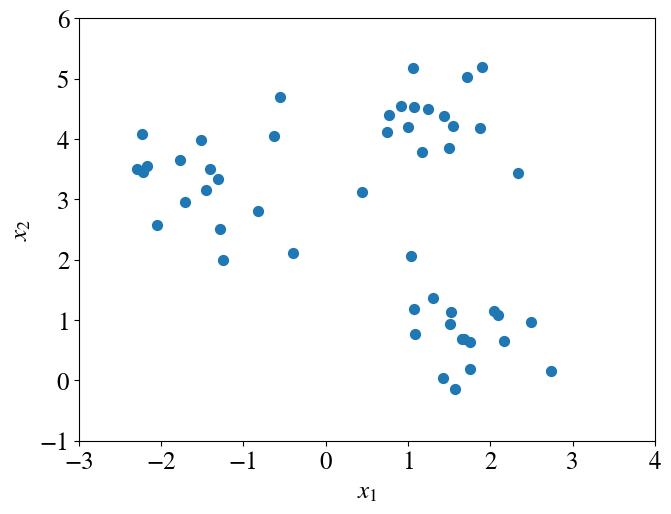

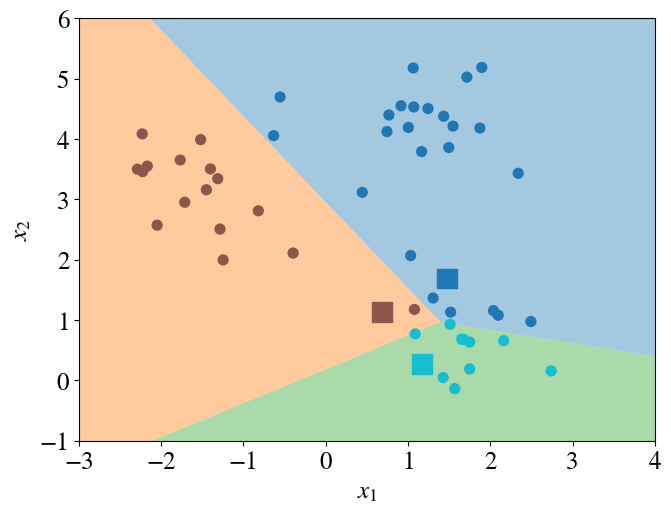

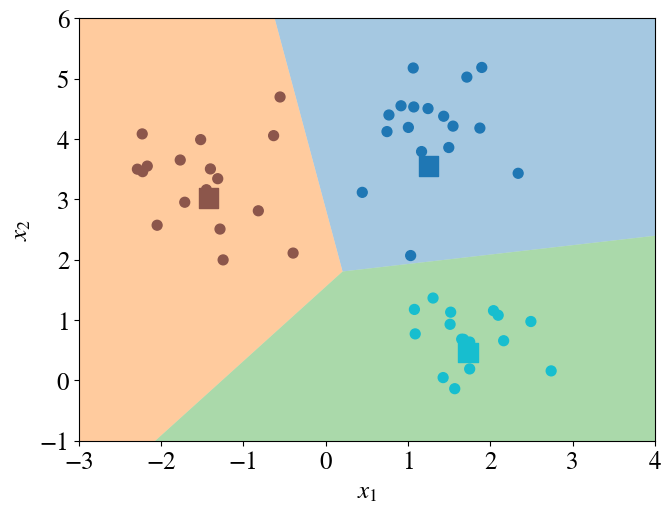

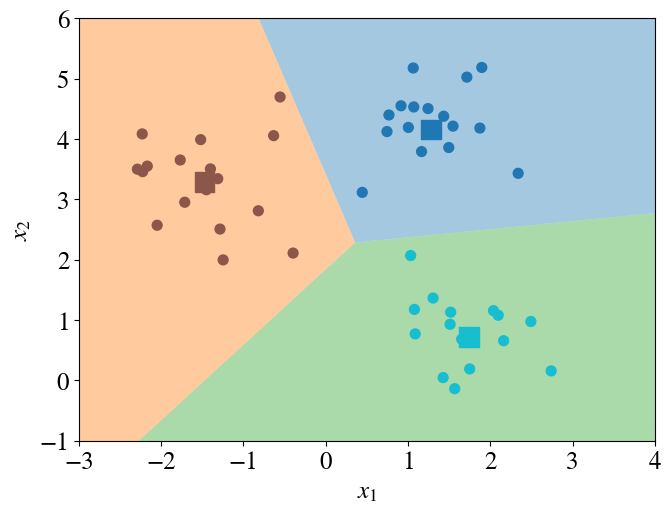

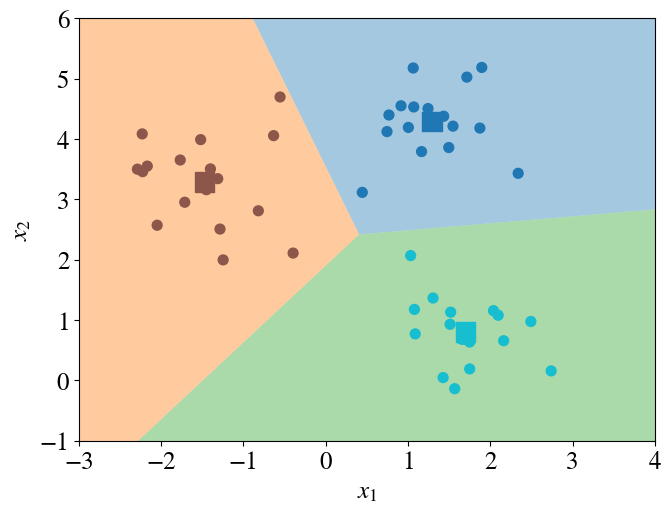

In [2]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin
from random import shuffle, random
from matplotlib.ticker import NullLocator
from scipy.spatial import Voronoi


matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})

x, _ = make_blobs(n_samples=50, centers=3, cluster_std=0.6, random_state=0)

def voronoi_finite_polygons_2d(vor, radius=None):
    """

    Credit: https://gist.github.com/pv/8036995

    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def find_clusters(x, n_clusters):
    # randomly set cluster centroids
    x_list = list(x)
    shuffle(x_list)
    centroids = np.array([[2 * random(), 4 * random()], [2 * random(), 4 * random()], [2 * random(), 4 * random()]])

    counter = 0

    plt.figure(counter)

    plt.scatter(x[:, 0], x[:, 1], s=50)

    ax = plt.gca()
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    plt.xlim(-3.0, 4.0)
    plt.ylim(-1, 6)

    fig1 = plt.gcf()

    fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

    counter = 1

    while True:

        plt.figure(counter)
        axes = plt.gca()

        # assign labels based on closest centroid
        labels = pairwise_distances_argmin(x, centroids)

        plt.scatter(x[:, 0], x[:, 1], c=[l + 1 for l in labels], s=50, cmap='tab10', zorder=2);

        plt.scatter(centroids[:, 0], centroids[:, 1], c=[1,2,3], s=200, cmap='tab10', marker="s", zorder=2);
        plt.xlim(-3.0, 4.0)
        plt.ylim(-1, 6)

        vor = Voronoi(centroids)

        # plot
        regions, vertices = voronoi_finite_polygons_2d(vor, 300)
        print("--")
        print(regions)
        print("--")
        print(vertices)

        # colorize
        for region in regions:
            polygon = vertices[region]
            plt.fill(*zip(*polygon), alpha=0.4, zorder=1)

        ax = plt.gca()
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')

        fig1 = plt.gcf()
        fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

        # find new centroids as the average of examples
        new_centroids = np.array([x[labels == i].mean(0) for i in range(n_clusters)])

        # check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

        counter += 1

    return centroids, labels

centroids, labels = find_clusters(x, 3)

### 9.2.3 클러스터 개수 결정하기

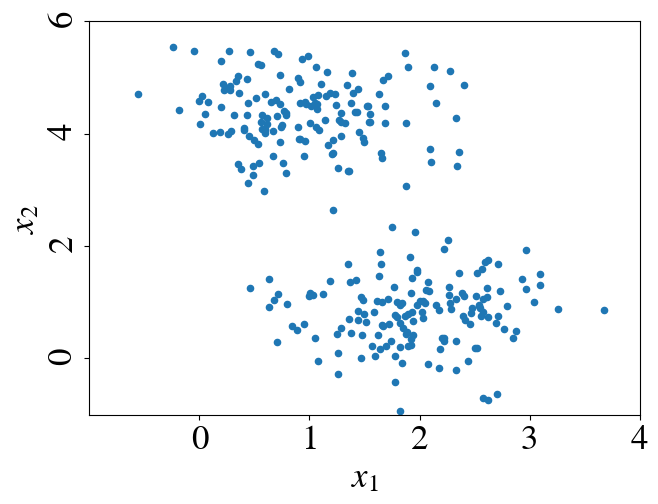

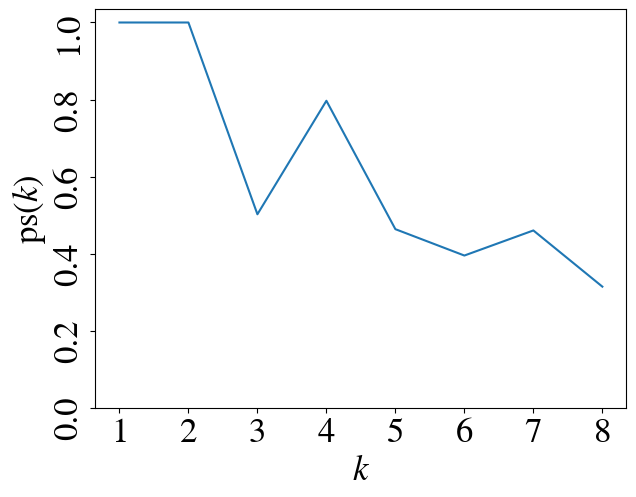

In [3]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import math

from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin
from random import shuffle
from scipy.spatial import Voronoi
from scipy.spatial import distance

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 25})

random_state = 0

## how many clusters do you want in your synthetic data?
centers = 2

x, _ = make_blobs(n_samples=300, centers=centers, cluster_std=0.6, random_state=random_state)

plt.figure(10000)
plt.scatter(x[:, 0], x[:, 1], s=20);
plt.xlim(-1, 4.0)
plt.ylim(-1, math.ceil(max(x[:, 1])))
plt.xticks(np.arange(int(min(x[:, 0])), math.ceil(max(x[:, 0]))+1, 1))
plt.yticks(np.arange(int(min(x[:, 1])), math.ceil(max(x[:, 1]))+1, 2), rotation='vertical')

ax = plt.gca()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

fig1 = plt.gcf()
fig1.subplots_adjust(top = 0.98, bottom = 0.16, right = 0.98, left = 0.12, hspace = 0, wspace = 0)

x_list = list(x)

random.Random(random_state).shuffle(x_list)

x_split = {}
x_split["train"] = np.array(x_list[:int(len(x_list)/2)])
x_split["test"] = np.array(x_list[int(len(x_list)/2):])

centroids_splits = {}
labels_splits = {}
counter = 100

def find_clusters(x, n_clusters, current_split):

    current_split_suffled = list(x_split[current_split])[:]
    shuffle(current_split_suffled)
    current_split_suffled = np.array(current_split_suffled)

    centroids = np.array(current_split_suffled[:n_clusters])

    while True:
        labels = pairwise_distances_argmin(x_split[current_split], centroids)

        # find new centroids as the average of examples
        new_centroids = np.array([x_split[current_split][labels == i].mean(0) for i in range(n_clusters)])

        # check for convergence
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, labels

def get_examples_from_cluster(j, test_points, test_labels):
    examples = []
    for e, l in zip(test_points, test_labels):
        if l == j:
            examples.append(e)
    return examples

def get_closest_centroid(example, centroids):
    min_distance = sys.float_info.max
    min_centroid = 0
    for c in centroids:
        if distance.euclidean(example, c) < min_distance:
            min_distance = distance.euclidean(example, c)
            min_centroid = c
    return min_centroid

def compute_strength(k, train_centroids, test_points, test_labels):
    D = np.zeros(shape=(len(test_points),len(test_points)))
    for x1, l1, c1 in zip(test_points, test_labels, list(range(len(test_points)))):
        for x2, l2, c2 in zip(test_points, test_labels, list(range(len(test_points)))):
            if tuple(x1) != tuple(x2):
                if tuple(get_closest_centroid(x1, train_centroids)) == tuple(get_closest_centroid(x2, train_centroids)):
                    D[c1,c2] = 1.0

    ss = []
    for j in range(k):
        s = 0
        examples_j = get_examples_from_cluster(j, test_points, test_labels)
        for x1, l1, c1 in zip(test_points, test_labels, list(range(len(test_points)))):
            for x2, l2, c2 in zip(test_points, test_labels, list(range(len(test_points)))):
                if tuple(x1) != tuple(x2) and l1 == l2 and l1 == j:
                    s += D[c1,c2]
        s = (1.0/(float(len(examples_j))*float(len(examples_j) - 1)))*s
        ss += [s]

    return min(ss)

strengths = []
ks = [1,2,3,4,5,6,7,8]
for k in ks:
    # print("k", k)
    for current_split in ["train", "test"]:
        counter += 1
        centroids, labels = find_clusters(x, k, current_split)

        centroids_splits[current_split] = centroids
        labels_splits[current_split] = labels
    s = compute_strength(k, centroids_splits["train"], x_split["test"], labels_splits["test"])
    strengths += [s]
    # print(s)

plt.figure(10001)
plt.plot(ks, strengths);
plt.xticks(np.arange(1, 9, 1))
plt.yticks(np.arange(0, 1.05, 0.2), rotation='vertical')

ax = plt.gca()
ax.set_xlabel('$k$')
ax.set_ylabel('$\\operatorname{ps}(k)$')

fig1 = plt.gcf()
fig1.subplots_adjust(top = 0.98, bottom = 0.15, right = 0.98, left = 0.15, hspace = 0, wspace = 0)

### 9.2.4 다른 군집 알고리즘

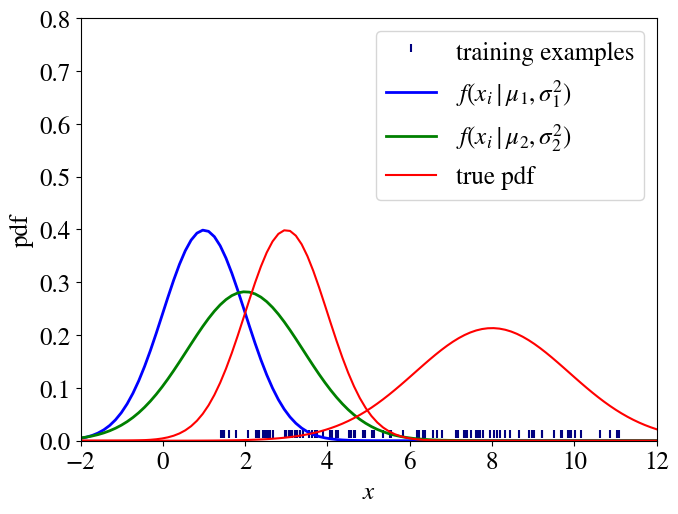

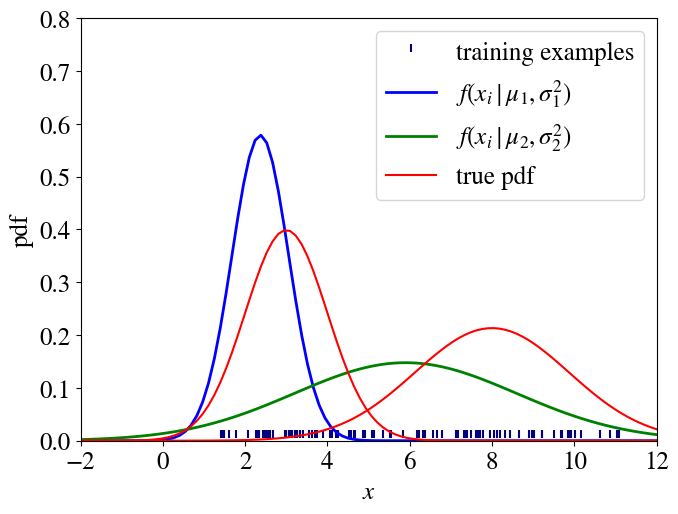

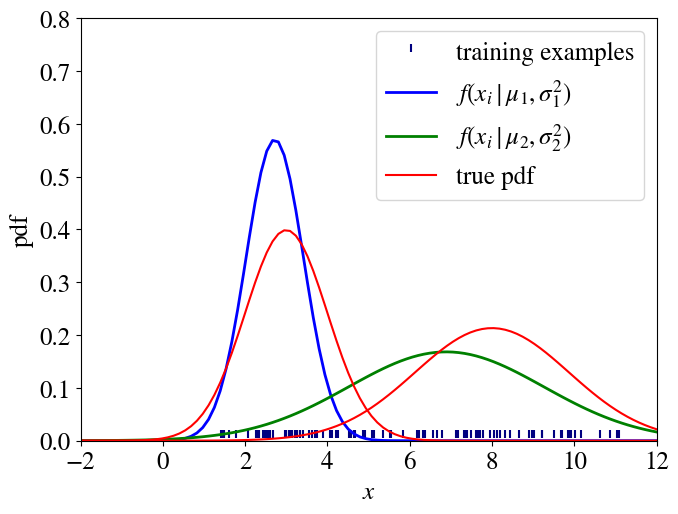

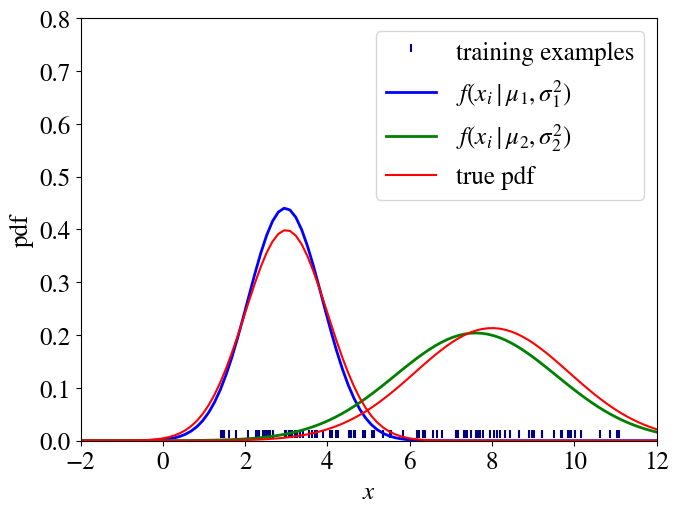

In [4]:
from __future__ import print_function
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.neighbors import KernelDensity

import scipy.integrate as integrate
from sklearn.kernel_ridge import KernelRidge

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 18})

mu1, sigma1 = 3.0, 1.0
mu2, sigma2 = 8.0, 3.5

def sample_points():
    s1 = np.random.normal(mu1, math.sqrt(sigma1), 50)

    s2 = np.random.normal(mu2, math.sqrt(sigma2), 50)

    return list(s1) + list(s2)

def compute_bi(mu1local, sigma1local, mu2local, sigma2local, phi1local, phi2local):
    bis = []
    for xi in x:
        bis.append((sp.stats.norm.pdf(xi, mu1local, math.sqrt(sigma1local)) * phi1local)/(sp.stats.norm.pdf(xi, mu1local, math.sqrt(sigma1local)) * phi1local + sp.stats.norm.pdf(xi, mu2local, math.sqrt(sigma2local)) * phi2local))
    return bis

# generate points used to plot
x_plot = np.linspace(-2, 12, 100)

# generate points and keep a subset of them
x = sample_points()

colors = ['red', 'blue', 'orange', 'green']
lw = 2

mu1_estimate = 1.0
mu2_estimate = 2.0
sigma1_estimate = 1.0
sigma2_estimate = 2.0

phi1_estimate = 0.5
phi2_estimate = 0.5

count = 0
while True:
    if count in [0, 1, 9, 39]:
        plt.figure(count)
        axes = plt.gca()
        axes.set_xlim([-2,12])
        axes.set_ylim([0,0.8])
        plt.xlabel("$x$")
        plt.ylabel("pdf")
        plt.scatter(x, [0.005] * len(x), color='navy', s=30, marker=2, label="training examples")
        plt.plot(x_plot, [sp.stats.norm.pdf(xp, mu1_estimate, math.sqrt(sigma1_estimate)) for xp in x_plot], color=colors[1], linewidth=lw, label="$f(x_i \\mid \\mu_1 ,\\sigma_1^2)$")
        plt.plot(x_plot, [sp.stats.norm.pdf(xp, mu2_estimate, math.sqrt(sigma2_estimate)) for xp in x_plot], color=colors[3], linewidth=lw, label="$f(x_i \\mid \\mu_2 ,\\sigma_2^2)$")
        plt.plot(x_plot, [sp.stats.norm.pdf(xp, mu1, math.sqrt(sigma1)) for xp in x_plot], color=colors[0], label="true pdf")
        plt.plot(x_plot, [sp.stats.norm.pdf(xp, mu2, math.sqrt(sigma2)) for xp in x_plot], color=colors[0])

        plt.legend(loc='upper right')
        plt.tight_layout()

        fig1 = plt.gcf()
        fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

    bis1 = compute_bi(mu1_estimate, sigma1_estimate, mu2_estimate, sigma2_estimate, phi1_estimate, phi2_estimate)
    bis2 = compute_bi(mu2_estimate, sigma2_estimate, mu1_estimate, sigma1_estimate, phi2_estimate, phi1_estimate)

    mu1_estimate = sum([bis1[i] * x[i] for i in range(len(x))]) / sum([bis1[i] for i in range(len(x))])
    mu2_estimate = sum([bis2[i] * x[i] for i in range(len(x))]) / sum([bis2[i] for i in range(len(x))])

    sigma1_estimate = sum([bis1[i] * (x[i] - mu1_estimate)**2 for i in range(len(x))]) / sum([bis1[i] for i in range(len(x))])
    sigma2_estimate = sum([bis2[i] * (x[i] - mu2_estimate)**2 for i in range(len(x))]) / sum([bis2[i] for i in range(len(x))])

    phi1_estimate = sum([bis1[i] for i in range(len(x))])/float(len(x))
    phi2_estimate = 1.0 - phi1_estimate

    # print(phi1_estimate)

    count += 1

    plt.close(count)

    if count > 50:
        break

## 9.3 차원 축소

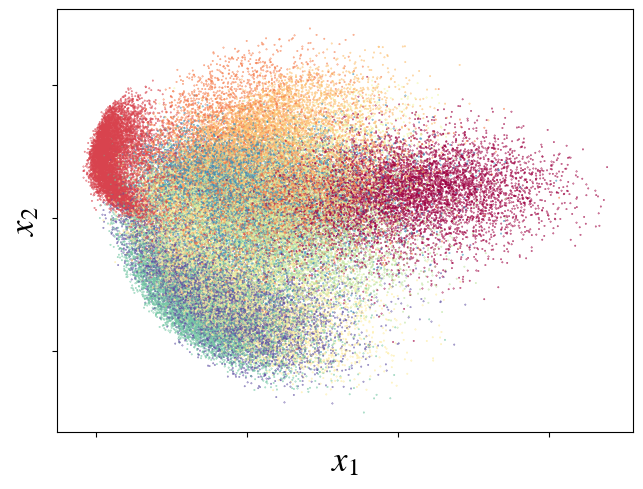

In [5]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math

from sklearn.decomposition import PCA

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 25})

from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


mnist = fetch_openml("mnist_784")

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(mnist.data)

plt.figure()

plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist.target.astype(int).tolist(), cmap="Spectral", s=0.1)

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

ax = plt.gca()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

fig1 = plt.gcf()

fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

plt.show()

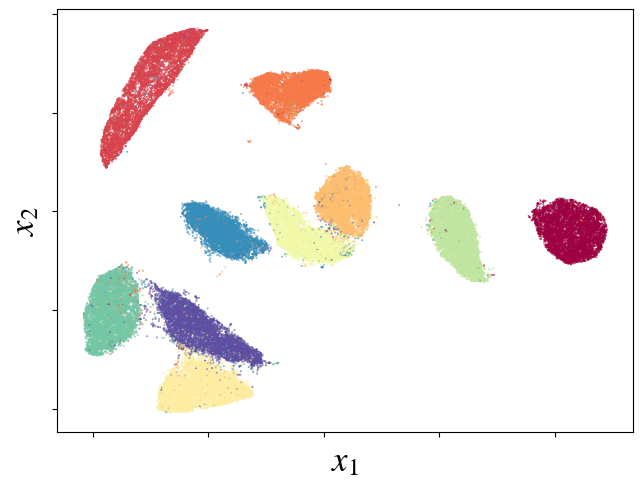

In [6]:
import umap

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 25})

reducer = umap.UMAP()
embedding = reducer.fit_transform(mnist.data)

plt.figure()

plt.scatter(embedding[:, 0], embedding[:, 1], c=mnist.target.astype(int).tolist(), cmap="Spectral", s=0.1)

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

ax = plt.gca()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

fig1 = plt.gcf()

fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

plt.show()

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0725 - val_loss: 0.0491
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0481 - val_loss: 0.0455
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0448 - val_loss: 0.0435
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0430 - val_loss: 0.0423
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0416 - val_loss: 0.0411
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


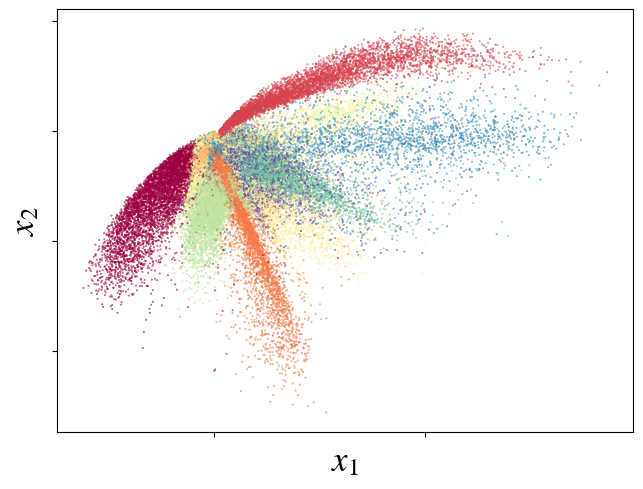

In [7]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784) / 255.0
x_test = x_test.reshape(10000, 784) / 255.0

m = Sequential()
m.add(Input(shape=(784,)))
m.add(Dense(512,  activation='elu'))
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(784,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1,
                validation_data=(x_test, x_test))

encoder = Model(m.inputs[0], m.get_layer('bottleneck').output)
embedding = encoder.predict(x_train)  # bottleneck representation

plt.figure()

plt.scatter(embedding[:,0], embedding[:,1], c=y_train, s=0.1, cmap='Spectral')

plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

ax = plt.gca()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

fig1 = plt.gcf()

fig1.subplots_adjust(top = 0.98, bottom = 0.1, right = 0.98, left = 0.08, hspace = 0, wspace = 0)

plt.show()